In [1]:
import pandas as pd 
import numpy as np 
import os 
# Personnal Import 
from utilities_DL import get_DataSet_and_invalid_dates,get_MultiModel_loss_args_emb_opts
from DL_class import MultiModelTrainer
from config import get_config,get_parameters
from plotting import plot_k_fold_split
from save_results import update_results_df
# ...

# Paths
folder_path = 'data/'

In [2]:
#Init and load data: 
H,W,D = 6,1,1
L = H+W+D 
step_ahead = 1

window_pred = np.arange(2*96)

# Load subway in data:
#file_name = 'preprocessed_subway_15_min.csv'
#file_name = 'subway_IN_interpol_neg_15_min_16Mar2019_1Jun2020.csv'
file_name = 'subway_IN_interpol_neg_15_min_2019_2020.csv'

# Load CRITER data : 
#file_name = 'preprocessed_CRITER_6min.csv'

# Get Parameters : 

In [3]:
# Choose Model :
model_name = 'STGCN' #'CNN'

# Choose config 
config = get_config(model_name = model_name,other_params= {'seq_length':L})
#config = get_config(model_name = model_name,learn_graph_structure = True,other_params= {'seq_length':L})  # MTGNN
args = get_parameters(config)

# Modification : 
args.epochs = 1
args.optimizer = 'adamw'
args.train_prop= 0.6
args.calib_prop=0.5
args.valid_prop= 0.2  

# Time Embedding: 
args.type_calendar = 'tuple'
args.embedding_dim = 2

# Validation : 
args.validation = 'sliding_window'
args.K_fold = 1

## Define fixed Dataset K_fold split for each trial: 

coverage period: 2019-01-01 00:00:00 - 2020-01-01 00:00:00


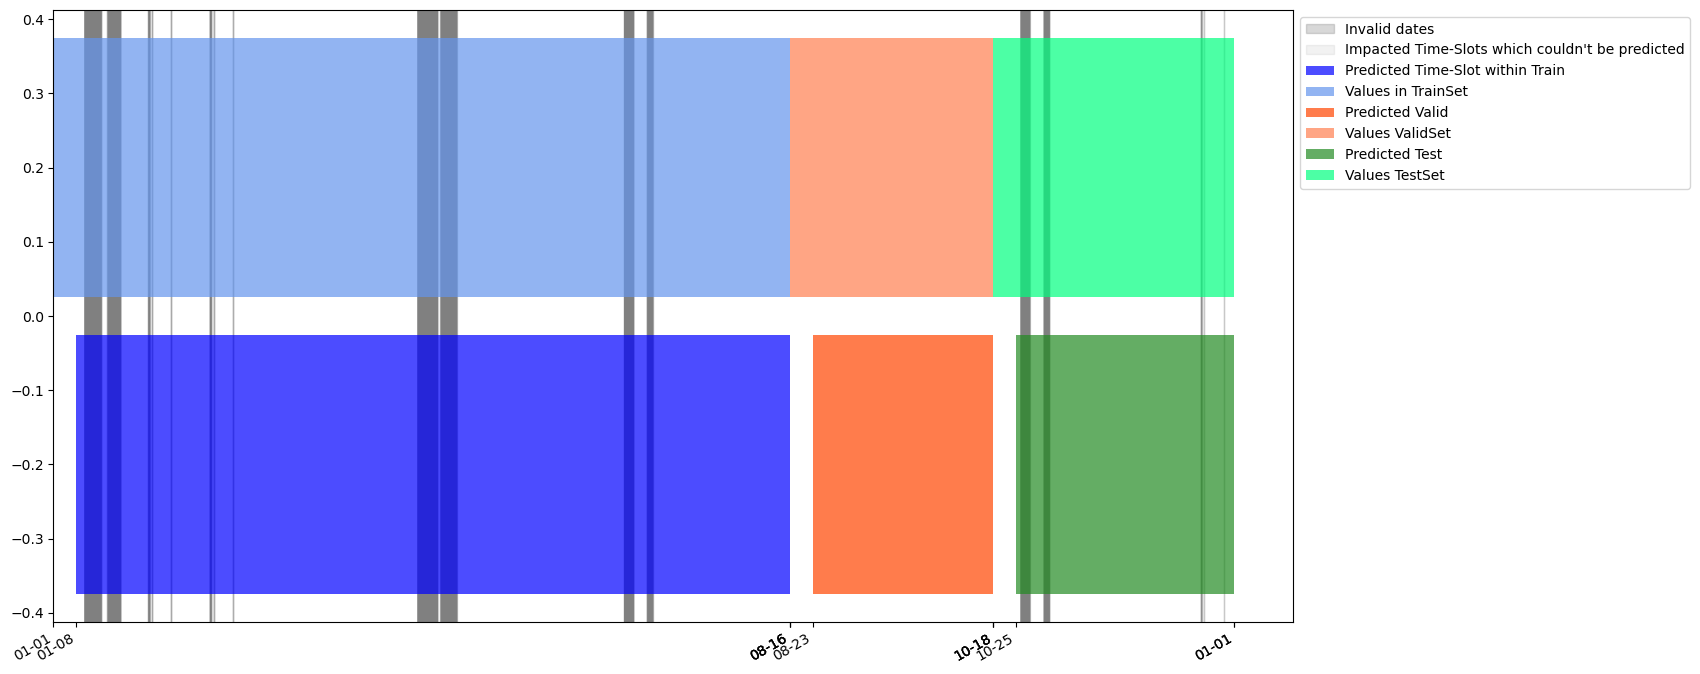

In [4]:
# Load dataset and invalid_dates
dataset,invalid_dates = get_DataSet_and_invalid_dates(folder_path,file_name,W,D,H,step_ahead,single_station = False)

# Train / Valid / Test split and Normalize for K-fold 
(Datasets,DataLoader_list,time_slots_labels_list,dic_clasxs2rpz_list,dic_rpz2class_list,nb_words_embedding_list) =  dataset.split_K_fold(args.K_fold,invalid_dates,args.train_prop, args.valid_prop,args.test_prop,args.calib_prop,args.validation,args.batch_size,calendar_class= args.calendar_class,no_common_dates_between_set = args.no_common_dates_between_set)

# Plot information about split and folds:
plot_k_fold_split(Datasets,invalid_dates)

# Test complet sur les 3 Top STGCN, avec sauvegarde du model :

In [6]:
model_name = 'STGCN'
#Init results dataframe:
results_df = pd.DataFrame()

file_name = 'preprocessed_subway_15_min.csv'
#file_name = 'subway_IN_interpol_neg_15_min_2019_2020.csv'

bool_plot_split = False  # Ne plot pas les Train/Valid/Test split sur les K_folds
for i,(calendar_class,position,specific_lr, type_calendar) in enumerate(zip([3,1,3],['input','input','input'],[True,True,False],['tuple','tuple','tuple'])):

    args.calendar_class = calendar_class
    args.position = position
    args.specific_lr = specific_lr
    args.type_calendar = type_calendar

    # Save Directory
    common_parameter = f"opt_{args.optimizer}/train_valid_calib_{args.train_prop}_{args.valid_prop}_{args.calib_prop}/"
    if args.model_name == 'STGCN':
        save_path =  f"save/{args.model_name}/{args.graph_conv_type}/{args.gso_type}/act_{args.act_fun}_Ks{args.Ks}/{common_parameter}"
    if args.model_name == 'CNN':
        save_path = f"save/{args.model_name}/h_dims{'_'.join(list(map(str,args.H_dims)))}_out_dims{'_'.join(list(map(str,args.C_outs)))}/{common_parameter}"  
    assert(save_path is not None),(f"save directory as not been designed for this model_name {args.model_name}")
    if args.time_embedding:
        save_path = save_path+ f"Specific_lr_{args.specific_lr}/CalendarClass{args.calendar_class}/position_{args.position}/"
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    # ...

    # Load dataset and invalid_dates 
    dataset,invalid_dates = get_DataSet_and_invalid_dates(folder_path,file_name,W,D,H,step_ahead,single_station = False)

    # Train / Valid / Test split and Normalize for K-fold 
    assert(args.calib_prop is not None),('args.calib_prop is None, which mean there is no possible calibration')
    (Datasets,DataLoader_list,time_slots_labels_list,dic_class2rpz_list,dic_rpz2class_list,nb_words_embedding_list) =  dataset.split_K_fold(args.K_fold,invalid_dates,args.train_prop, args.valid_prop,args.test_prop,args.calib_prop,args.validation,args.batch_size,calendar_class= args.calendar_class,no_common_dates_between_set = args.no_common_dates_between_set)

    # Plot information about split and folds:
    if bool_plot_split:
        plot_k_fold_split(Datasets,invalid_dates)


    # Load associated K_folds Models: 
    (loss_function,Model_list,Optimizer_list,args_embedding) = get_MultiModel_loss_args_emb_opts(args,nb_words_embedding_list,dic_class2rpz_list)
    multimodeltrainer = MultiModelTrainer(Model_list,DataLoader_list,args,Optimizer_list,loss_function,scheduler = None,args_embedding=args_embedding,ray= False,save_path = save_path)
    (mean_picp,mean_mpiw,dict_last_from_mean_of_folds,dict_best_from_mean_of_folds) = multimodeltrainer.K_fold_validation()

    # Svae results 
    results_df = update_results_df(results_df,args, mean_picp,mean_mpiw,dict_last_from_mean_of_folds,dict_best_from_mean_of_folds,i)
                            
results_df.to_csv('save_results.csv')
results_df

coverage period: 2019-03-16 00:00:00 - 2019-06-01 00:00:00
Ko: 8, enable padding: True


K_fold 0
start training
epoch: 0 
 min\epoch : 0.18
coverage period: 2019-03-16 00:00:00 - 2019-06-01 00:00:00
Ko: 8, enable padding: True


K_fold 0
start training
epoch: 0 
 min\epoch : 0.17
coverage period: 2019-03-16 00:00:00 - 2019-06-01 00:00:00
Ko: 8, enable padding: True


K_fold 0
start training
epoch: 0 
 min\epoch : 0.17


,CalendarClass,Position,Specific_lr,Type_calendar,PICP_mean,MPIW_mean,mean_last_train_loss,std_of_lasts_train_loss,mean_last_valid_loss,std_of_lasts_valid_loss,best_mean_train_loss,std_of_best_mean_train_loss,best_mean_valid_loss,std_of_best_mean_valid_loss
0,3,input,True,tuple,0.999770,1.176026,0.084893,NaN,0.058792,NaN,0.084893,NaN,0.058792,NaN
1,1,input,True,tuple,0.968087,0.651686,0.056303,NaN,0.036303,NaN,0.056303,NaN,0.036303,NaN
2,3,input,False,tuple,0.999082,1.044858,0.081788,NaN,0.052269,NaN,0.081788,NaN,0.052269,NaN


## Loop on different config:

In [9]:
#Init results dataframe:
results_df = pd.DataFrame()
i = 0

file_name = 'preprocessed_subway_15_min.csv'
#file_name = 'subway_IN_interpol_neg_15_min_2019_2020.csv'


args.epochs = 1
bool_plot_split = False  # Ne plot pas les Train/Valid/Test split sur les K_folds


# Set Variable Config : 
Calendar_class = [1,2,3]
Position = ['input','output']
Specific_lr = [True,False]
Type_calendar = ['tuple','unique_long_embedding']  # Lors qu'il y a 'tuple', le matching tensor renvoit le tuple associé au calendar class.
args.time_embedding = True   # Be sure the time embedding is activated


# Loop on all possible config:
for model_name in ['STGCN']:

for calendar_class in Calendar_class:
    for position in Position:
        for specific_lr in Specific_lr:
            for type_calendar in Type_calendar:

                # Modify 'args':
                args.calendar_class = calendar_class
                args.position = position
                args.specific_lr = specific_lr
                args.type_calendar = type_calendar
                # ...

                # Save Directory
                if args.model_name == 'STGCN':
                    save_path =  f"save/{args.model_name}/{args.graph_conv_type}/{args.gso_type}/act_{args.act_fun}_Ks{args.Ks}_opt_{args.optimizer}/"
                    if args.time_embedding:
                        save_path = save_path + f"Specific_lr_{args.specific_lr}/CalendarClass{args.calendar_class}/position_{args_embedding.position}/"

                if args.model_name == 'CNN':
                    save_path = f"save/{args.model_name}/h_dims{'_'.join(list(map(str,args.H_dims)))}_out_dims{'_'.join(list(map(str,args.C_outs)))}_opt_{args.optimizer}/"  
                    if args.time_embedding:
                        save_path = save_path+ f"Specific_lr_{args.specific_lr}/CalendarClass{args.calendar_class}/position_{args_embedding.position}/"
                if not os.path.exists(save_path):
                    os.makedirs(save_path)

                # Load dataset and invalid_dates 
                dataset,invalid_dates = get_DataSet_and_invalid_dates(folder_path,file_name,W,D,H,step_ahead,single_station = False)

                # Train / Valid / Test split and Normalize for K-fold 
                assert(args.calib_prop is None),('args.calib_prop is not None, which mean there is different train_set for each trial')
                (Datasets,DataLoader_list,time_slots_labels_list,dic_class2rpz_list,dic_rpz2class_list,nb_words_embedding_list) =  dataset.split_K_fold(args.K_fold,invalid_dates,args.train_prop, args.valid_prop,args.test_prop,args.calib_prop,args.validation,args.batch_size,calendar_class= args.calendar_class,no_common_dates_between_set = args.no_common_dates_between_set)

                # Plot information about split and folds:
                if bool_plot_split:
                    plot_k_fold_split(Datasets,invalid_dates)


                # Load associated K_folds Models: 
                (loss_function,Model_list,Optimizer_list,args_embedding) = get_MultiModel_loss_args_emb_opts(args,nb_words_embedding_list,dic_class2rpz_list)
                multimodeltrainer = MultiModelTrainer(Model_list,DataLoader_list,args,Optimizer_list,loss_function,scheduler = None,args_embedding=args_embedding,ray= False,save_path = save_path)
                (mean_picp,mean_mpiw,dict_last_from_mean_of_folds,dict_best_from_mean_of_folds) = multimodeltrainer.K_fold_validation()

                # Svae results 
                results_df = update_results_df(results_df,args, mean_picp,mean_mpiw,dict_last_from_mean_of_folds,dict_best_from_mean_of_folds,i)
                i += 1
                            
results_df.to_csv('save_results.csv')
results_df

coverage period: 2019-03-16 00:00:00 - 2019-06-01 00:00:00


K_fold 0
start training
epoch: 0 
 min\epoch : 0.00
K_fold 1
start training
epoch: 0 
 min\epoch : 0.00
K_fold 2
start training
epoch: 0 
 min\epoch : 0.00
K_fold 3
start training
epoch: 0 
 min\epoch : 0.00
K_fold 4
start training
epoch: 0 
 min\epoch : 0.00
K_fold 5
start training
epoch: 0 
 min\epoch : 0.00
K_fold 6
start training
epoch: 0 
 min\epoch : 0.00
torch.Size([50, 3])
coverage period: 2019-03-16 00:00:00 - 2019-06-01 00:00:00


K_fold 0
start training
epoch: 0 
 min\epoch : 0.00
K_fold 1
start training
epoch: 0 
 min\epoch : 0.00
K_fold 2
start training
epoch: 0 
 min\epoch : 0.00
K_fold 3
start training
epoch: 0 
 min\epoch : 0.00
K_fold 4
start training
epoch: 0 
 min\epoch : 0.00
K_fold 5
start training
epoch: 0 
 min\epoch : 0.00
K_fold 6
start training
epoch: 0 
 min\epoch : 0.00
torch.Size([50, 3])
coverage period: 2019-03-16 00:00:00 - 2019-06-01 00:00:00


K_fold 0
start training
epoch: 0 
 min\epoch : 0.

,CalendarClass,Position,Specific_lr,Type_calendar,PICP_mean,MPIW_mean,mean_last_train_loss,std_of_lasts_train_loss,mean_last_valid_loss,std_of_lasts_valid_loss,best_mean_train_loss,std_of_best_mean_train_loss,best_mean_valid_loss,std_of_best_mean_valid_loss
0,1,input,True,tuple,0.136815,-0.034300,0.236532,0.121876,0.215081,0.121876,0.236532,0.121876,0.215081,0.099011
1,1,input,True,unique_long_embedding,0.151789,-0.043997,0.260791,0.103233,0.239759,0.103233,0.260791,0.103233,0.239759,0.097305
2,1,input,False,tuple,0.100481,-0.062387,0.226823,0.094724,0.216355,0.094724,0.226823,0.094724,0.216355,0.115369
3,1,input,False,unique_long_embedding,0.293750,0.141665,0.187142,0.084360,0.176537,0.084360,0.187142,0.084360,0.176537,0.116669
4,1,output,True,tuple,0.349490,0.161578,0.189271,0.103875,0.140770,0.103875,0.189271,0.103875,0.140770,0.119882
5,1,output,True,unique_long_embedding,0.083630,-0.027184,0.238417,0.110851,0.207789,0.110851,0.238417,0.110851,0.207789,0.091693
6,1,output,False,tuple,0.176593,-0.028057,0.282099,0.149054,0.264267,0.149054,0.282099,0.149054,0.264267,0.129158
7,1,output,False,unique_long_embedding,0.110375,0.054805,0.261430,0.101570,0.245074,0.101570,0.261430,0.101570,0.245074,0.095320
8,2,input,True,tuple,0.207784,0.085829,0.237601,0.111259,0.216035,0.111259,0.237601,0.111259,0.216035,0.113280
9,2,input,True,unique_long_embedding,0.220663,0.106222,0.189820,0.088428,0.171047,0.088428,0.189820,0.088428,0.171047,0.080525


In [8]:
multimodeltrainer.mpiw

[-0.2086971551179886,
 0.1885807067155838,
 -0.21632690727710724,
 -0.19072620570659637,
 0.182303324341774,
 -0.07127311825752258,
 -0.17025382816791534]